# Introduction and Background

In this notebook we demonstrate how to use learning models to correlate atomic structures with materials properties. We cover two standard linear methods: linear regression (LR) and principal components analysis (PCA). If you are already familiar with LR and PCA, you can continue onto [Principal Covariates Regression](2_PrincipalCovariatesRegression.ipynb).

For each model, we first go step-by-step through the derivation, with equations, embedded links, and citations supplied where useful. Second, we demonstrate a "Utility Class" for the models, which can be found in the utilities folder and contains all necessary functions.

The input data is stored in a $n_{samples}\times n_{features}$ feature matrix $\mathbf{X}$, and the properties one might want to correlate structural features with in a $n_{samples}\times n_{properties}$ matrix $\mathbf{Y}$. 

Note that, as discussed in [Importing Data](X_ImportingData.ipynb), features and properties are centered and normalized. They have also been split into training and testing sets, denoted ($\mathbf{X}_{train}$, $\mathbf{Y}_{train}$) and ($\mathbf{X}_{test}$, $\mathbf{Y}_{test}$).

In [1]:
#!/usr/bin/env python3

import sys, os

# Maths things
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Local Utilities for Notebook
sys.path.append('../')
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_projection, plot_regression, 
    plot_simple, 
    get_cmaps, table_from_dict,
    check_mirrors
)
from utilities.kernels import linear_kernel, gaussian_kernel, center_kernel
from utilities.classes import PCA, LR

cmaps = get_cmaps()
plt.style.use('../utilities/kernel_pcovr.mplstyle')
dbl_fig=(2*plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1])

First, we must load the data. For a step-by-step explanation of this, please see [Importing Data](X_ImportingData.ipynb).

In [2]:
var_dict = load_variables()
locals().update(var_dict)

0 frames in total.
Shape of Input Data is  (1362, 2520) .
Taking a subsampling of  200 features
Splitting Data Set


Now we have these variables at our disposal:

In [3]:
x=%who_ls ndarray float64 list int str
print(x)

['K_test', 'K_train', 'X', 'X_center', 'X_scale', 'X_split', 'X_test', 'X_train', 'Y', 'Y_center', 'Y_scale', 'Y_test', 'Y_train', 'i_test', 'i_train', 'n_PC', 'n_test', 'n_train']


# Principal Component Analysis (PCA)

In principal component analysis (PCA), we seek to reduce the dimensionality of the input data $\mathbf{X}$ such that the first few dimensions, which are easiest for humans to visualize, account for as much of the [variance](https://en.wikipedia.org/wiki/Variance) in the input data as possible. In this way, we reduce the dimensionality of the input data while retaining and enhancing the natural diversity in the data. In order to accomplish this, the input data are projected onto a subset of the eigenvectors of the covariance matrix of the data, namely the eigenvectors corresponding to the $n_{PCA}$ largest eigenvalues
[(Pearson, 1901)](http://doi.org/10.1080/14786440109462720), 
[(Hotelling, 1936)](https://www.jstor.org/stable/2333955),
[(Wikipedia)](https://en.wikipedia.org/wiki/Principal_component_analysis).

<!---<span style="color:red">RKC: We need some sort of image/graphic here</span> -->

## Reconstruction Error of a Projection

PCA is the attempt to find an approximation of the $n_{samples}\times n_{features}$ feature matrix in terms of a $n_{samples}\times n_{PCA}$  **latent space** matrix, that we define as $\mathbf{T} =\mathbf{X} \mathbf{P}_{XT}$.

The matrix $\mathbf{P}_{XT}$ projects between feature space and latent space. The approximation of the feature matrix in terms of latent space coordinates can be written in terms of another linear projection $\mathbf{P}_{TX}$ as $\mathbf{X}_{PCA} = \mathbf{T} \mathbf{P}_{TX}$. 

Requiring that  $\mathbf{X}_{PCA} \mathbf{P}_{XT} = \mathbf{T} $ (i.e. that $\mathbf{X}_{PCA}$ a perfect approximation of the portion of the feature space that is projected to the latent space) implies that $\mathbf{P}_{TX}\mathbf{P}_{XT}=\mathbf{I}$. Without loss of generality we take the projection matrix to the latent space to be orthogonal, which implies that $\mathbf{P}_{TX}=\mathbf{P}_{XT}^T$.

The **reconstruction error** is defined as the difference between the original feature matrix and that approximated using only latent-space information, 

\begin{equation}
\ell=\lVert\mathbf{X}-\mathbf{X}_{PCA}\rVert^2  = 
\lVert\mathbf{X}-\mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{XT}^T\rVert^2
\end{equation}

where $\lVert \cdot \rVert$ denotes the [Frobenius norm](http://mathworld.wolfram.com/FrobeniusNorm.html). 

Using the orthogonality of $\mathbf{P}_{XT}$, $\mathbf{P}_{XT}^T\mathbf{P}_{XT} = \mathbf{I}$, and the [matrix relations](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf):

\begin{align}
(1) & \quad\left\lVert\mathbf{A}\right\rVert^2=\operatorname{Tr}(\mathbf{A}\mathbf{A}^T) \\
(2) & \quad\left(\mathbf{I}-\mathbf{P}_{XT} \mathbf{P}_{XT}^T\right)^2 = \left(\mathbf{I}-\mathbf{P}_{XT} \mathbf{P}_{XT}^T\right)\\
(3) & \quad\operatorname{Tr}(\mathbf{A B C}) = \operatorname{Tr}(\mathbf{B C A})
\end{align}

we write

\begin{equation}
\ell=\operatorname{Tr}\left(\mathbf{X} \left(\mathbf{I}-\mathbf{P}_{XT} \mathbf{P}_{XT}^T\right) \mathbf{X}^T \right).
\end{equation}

## The Principal Components

Finding the optimal projection to the latent space amounts to minimizing the loss $\ell$ within the space of orthogonal matrices. Using another time the fact that the trace of a product is invariant to circular permutations of the factors (Eq. (3) above), and given that  $\operatorname{Tr}\left(\mathbf{X}\mathbf{X}^T\right)$ is a constant, minimizing $\ell$ is equivalent to _maximising_ the similarity $\rho$,

\begin{equation}
\rho=\operatorname{Tr}\left(\mathbf{P}_{XT}^T \mathbf{X}^T \mathbf{X} \mathbf{P}_{XT}\right).
\end{equation}

By recognizing that the equation for $\mathbf{\rho}$ can be written in terms of a [Rayleigh Quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient#Special_case_of_covariance_matrices), we note that $\rho$ is maximised when $\mathbf{P}_{XT}$ is the matrix built out of the $n_{PCA}$ principal eigenvectors of $\mathbf{X}^T\mathbf{X}=\mathbf{C}$.

## The Covariance and Eigendecomposition

To perform PCA in practice, we first compute the covariance matrix $\mathbf{C}=\mathbf{X}^T\mathbf{X}$ and its eigendecomposition,

\begin{equation}
\mathbf{C} = \mathbf{U}_C \mathbf{\Lambda}_C \mathbf{U}_C^T,
\end{equation}

where $\mathbf{\Lambda}_C$ is a matrix with the eigenvalues of $\mathbf{C}$ on the diagonal in decreasing order (top left to bottom right), and $\mathbf{U}_C$ is a matrix containing the corresponding eigenvectors as columns.

Note that, when divided by the number of samples, the inner product of the training feature matrices only corresponds to an estimator of the covariance of the data when the feature matrix has been previously centered, which it has been here. [(Wikipedia)](https://en.wikipedia.org/wiki/Covariance#Relationship_to_inner_products)

In [4]:
C = np.matmul(X_train.T, X_train)

v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

The computation and sorting of the eigenvalues can also be performed using the `sorted_eig(matrix, threshold, n)` function in `utilities/general.py`.

Given that we have scaled the features to have unit variance, the magnitude of the eigenvalues, relative to the sum of the eigenvalues, indicates the fraction of the variance associated with each principal component.

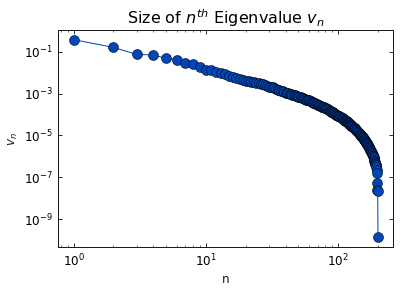

In [5]:
plt.loglog(np.asarray(range(len(v_C)))+1, v_C/n_train, marker='o')
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$")
plt.xlabel("n"); plt.ylabel(r"$v_n$");

## The Low-Dimensional Projection and Approximation

As discussed above, the projection matrix on the PCA latent space corresponds to the orthonormal basis defined by the eigenvectors $\mathbf{P}_{XT}= \hat{\mathbf{U}}_C$, where $\hat{\mathbf{U}}_C$ includes only the first $n_{PCA}$ eigenvectors of the covariance ($\mathbf{U}_C$) as columns and is therefore of size $n_{samples}\times n_{PCA}$. The resulting projection yields the low-dimensional representation,

\begin{equation}
\mathbf{T} = \mathbf{X}\hat{\mathbf{U}}_C,
\end{equation}

PCA projections give a simplified representation of the data that may (or may not!) correlate with the property of interest, but should include most of the variance in the feature space.

In [6]:
print(f"Our low-dimensional space contains {n_PC} components.")

Our low-dimensional space contains 2 components.


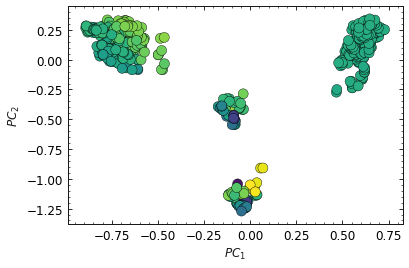

In [7]:
PXT = U_C[:,:n_PC]
PTX = PXT.T

T = np.matmul(X_train, PXT)

plot_projection(Y_train, T, **cmaps)

As mentioned previously, the low-dimensional projections can also be used to construct a low-rank approximant of the input space, 

\begin{equation}
\mathbf{X}_{PCA} = \mathbf{T} \mathbf{P}_{XT}^T = \mathbf{T}\hat{\mathbf{U}}_C^T,
\end{equation}

i.e., vectors that have the same dimensionality of the initial features, but actually are just lying in a $n_{PCA}$-dimensional subspace. This yields our original projection equation $\mathbf{X}_{PCA} = \mathbf{X}\mathbf{P}_{XT}\mathbf{P}_{XT}^T$.

In the plot below, we represent the first two components of the feature space for $\mathbf{X}$ and $\mathbf{X}_{PCA}$. Given the high dimensionality of the feature space, the figure cannot quantitatively represent the accuracy of the reconstruction.

In [8]:
X_PCA = np.matmul(T, PTX)

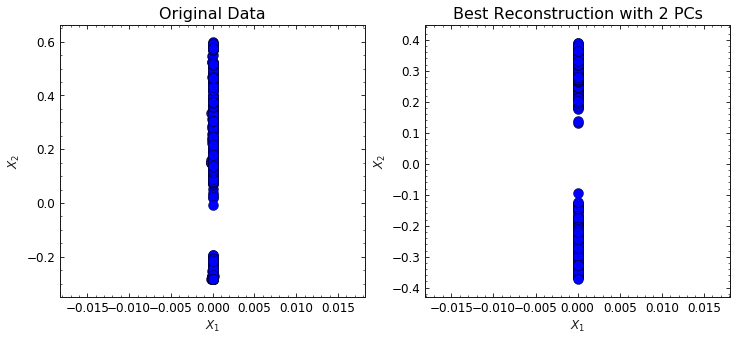

In [9]:
fig, ax = plt.subplots(1,2, figsize=dbl_fig)
plot_simple(X_train, fig=fig, ax=ax[0], title="Original Data", **cmaps)
plot_simple(X_PCA, fig=fig, ax=ax[1], title="Best Reconstruction with {} PCs".format(n_PC), **cmaps)

## Out-of-sample projection

Once PCA has been performed on a **training set** and the eigenvectors have been found, it is possible to find low-dimensional projections (and reconstructed approximants) of other data points (the **test set**), which is approximately optimal in the same sense as the PCA loss.

If $\mathbf{X}_{test}$ is the feature matrix of the test points, their latent-space projection can be obtained as $\mathbf{T}_{test}=\mathbf{X}_{test}\mathbf{P}_{XT}$

In [10]:
T_PCA_test = np.matmul(X_test, PXT)
X_test_PCA = np.matmul(T_PCA_test,PTX)

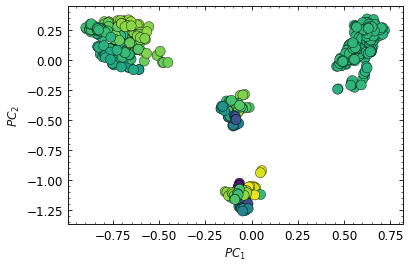

In [11]:
plot_projection(Y_test, T_PCA_test, **cmaps)

## Error and Loss

We compute errors for the out-of-sample projections based on the same expression for the loss that we used to build the PCA projection for the training set:

\begin{equation}
\ell=\lVert\mathbf{X}_{test}-\mathbf{X}_{PCA, test}\rVert^2 = \lVert\mathbf{X}_{test}-\mathbf{X}_{test}\mathbf{P}_{XT}\mathbf{P}_{TX}\rVert^2 
\end{equation}

We have supplied a utility `get_stats` and a markdown table converter for statistics in `utilities/plotting.py`, which can be called to compare or print statistics:

In [12]:
table_from_dict([get_stats(x=X_train, y=Y_train, t=T, xr=X_PCA), 
                 get_stats(x=X_test, y=Y_test, t=T_PCA_test, xr=X_test_PCA)], 
                 headers = ["Training", "Testing"], 
                 title="PCA")

<center><b> PCA </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 1.0142 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.536512 </td><td> 0.539828 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 0.463488 </td><td> 0.474371 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.463488 </td><td> 0.475079 </td></tr></table></center>

As you may assume, the error in the projection decreases as we include more components. Here we show the decrease in the approximation error, and show how the first two features in $\mathbf{X}_{PCA}$ converge to the exact value as the number of selected components approaches the number of features of $\mathbf{X}$.

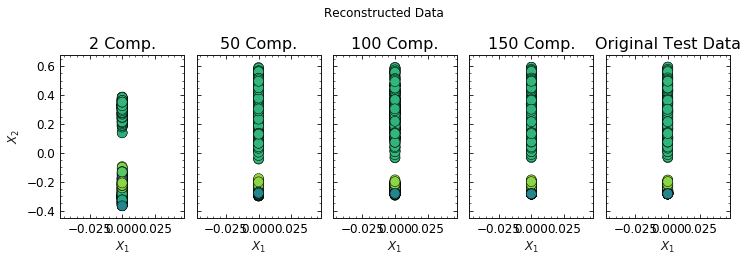

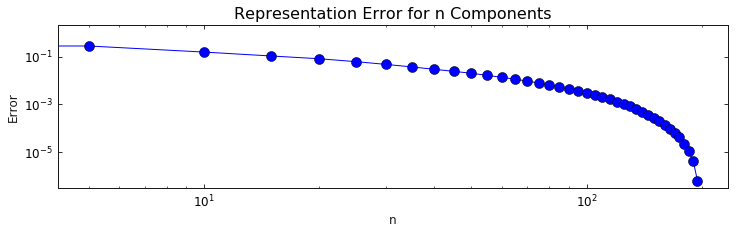

In [13]:
trials = range(X_test.shape[1])[::5]

n_plot = 4
fsize = (3*n_plot,3)

fig, ax = plt.subplots(1, n_plot+1, figsize=fsize, sharex=True, sharey=True)

for i,n in enumerate(trials[::int(len(trials)/n_plot)]):
    n = max(n,2)
    PXT = U_C[:,:n]
    PTX = PXT.T
    
    X_r = np.matmul( np.matmul(X_test, PXT), PTX)
    
    ax[i].scatter(X_r[:,0], X_r[:,1], c=Y_test[:,0], linewidth=0.5, edgecolor='k')
    ax[i].set_title(f"{n} Comp.")
    ax[i].set_xlabel(r"$X_1$")

ax[-1].scatter(X_test[:,0], X_test[:,1], c=Y_test[:,0], linewidth=0.5, edgecolor='k')
ax[-1].set_title("Original Test Data")
ax[-1].set_xlabel(r"$X_1$")
ax[0].set_ylabel(r"$X_2$")

fig.suptitle("Reconstructed Data", y=1.1)
fig.subplots_adjust(wspace=0.1)

plt.figure(figsize=fsize)
plt.loglog(trials, \
           [((X_test-np.matmul(np.matmul(X_test, U_C[:, 0:n]), U_C[:,:n].T))**2).mean(axis=0).sum() for n in trials], \
           "b-", marker='o')
plt.title(r"Representation Error for n Components")
plt.xlabel("n"); plt.ylabel("Error");

# Classical Multidimensional Scaling (MDS)

A reduction in the dimension of the feature space is also achieved with a different logic that underlies several dimensionality reduction techniques known as [multidimensional scaling (MDS)](https://en.wikipedia.org/wiki/Multidimensional_scaling) [(Torgerson1952)](https://doi.org/10.1007/BF02288916).
In MDS, the projected feature space is chosen to preserve the _pairwise distances_ of the original space, defining the loss (in MDS known as the $\textit{strain}$):

\begin{equation}
    \ell = \sum_{j}\sum_{i<j} \left[\left( d(X_i,X_j) - d(T_i - T_j)\right)^2\right]
\label{eq:loss-mds-sum}
\end{equation}

where $d$ is a distance measure and $X_i$ and $T_i$ refer to the $i^{th}$ samples in the full and projected feature matrices $\mathbf{X}$ and $\mathbf{T}$.

In *classical MDS*, also known as Principal _Coordinates_ Analysis, the distance between features is the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). If we assume that $\mathbf{X}$ is centered, i.e. $\bar{X} = 0$ and construct a triangle between $X_i$, $X_j$, and 0, we use the law of cosines to retrieve the Euclidean distance:

\begin{equation}
d^2(X_i,X_j) = \lVert X_i \rVert^2 + \lVert X_j \rVert^2 - 2 \langle X_i, X_j\rangle
\end{equation}

Given that $ij^{th}$ element of the Gram matrix $\mathbf{K} = \mathbf{X} \mathbf{X}^T$ contains the inner products of $X_i$ and $X_j$, we then write our distance in terms of $K_{ij}$.

\begin{equation}
d^2(X_i,X_j) = K_{ii} + K_{jj} - 2 K_{ij}
\end{equation}

Therefore, there is a 1:1 mapping between the distance matrix $\mathbf{D}$ and the Gram matrix $\mathbf{K}$. This motivates the choice of a related (but not equivalent) loss function

\begin{equation}
    \ell = \lVert \mathbf{X}\mathbf{X}^T - \mathbf{T}\mathbf{T}^T\rVert^2,
\label{eq:loss-mds}
\end{equation}

also known as Torgerson scaling, that aims to find the best low-rank approximation of the Gram matrix.

The 1:1 relation between the Euclidean distance and the scalar product matrix means that if one finds a solution that zeroes the Torgerson loss, that solution also perfectly reproduces the distance matrix. However, approximate solutions to the Gram matrix matching problem are not necessarily local optima of the distance matrix matching problem. 

Further discussion of this derivation can be found in [The Elements of Statistical Learning: Data Mining, Inference, and Prediction](https://doi.org/10.1007/978-0-387-84858-7), [section 18.5.2](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12.pdf). Also featured in this great [stackexchange discussion.](https://stats.stackexchange.com/questions/14002/whats-the-difference-between-principal-component-analysis-and-multidimensional) 

In [14]:
K = np.matmul(X_train, X_train.T)
K = center_kernel(K)

## The Low-Dimensional Projection and Approximation


If the eigenvalue decomposition of the Gram matrix reads $\mathbf{K} = \mathbf{U}_\mathbf{K} \mathbf{\Lambda}_\mathbf{K} \mathbf{U}_\mathbf{K}^T$, $\ell$ is minimized when $\mathbf{T}\mathbf{T}^T$ is given by the singular value decomposition of $\mathbf{K}$, that is by taking 

\begin{equation}
\mathbf{T} = \hat{\mathbf{U}}_\mathbf{K} \hat{\mathbf{\Lambda}}_\mathbf{K}^{1/2}
\label{eq:tuk}
\end{equation}

restricted to the largest $n_{MDS}$ eigenvectors. 

In [15]:
n_MDS = 2 # size of low-dimensional space

v_K, U_K = np.linalg.eigh(K)


# U_K/v_K are already sorted, but in *inKreasing* order, so reverse them
U_K = np.flip(U_K, axis=1)
v_K = np.flip(v_K, axis=0)
U_K = U_K[:,v_K>0]
v_K = v_K[v_K>0]

The resulting projection is might seem a bit familiar (more on this in Sec. 3.3).

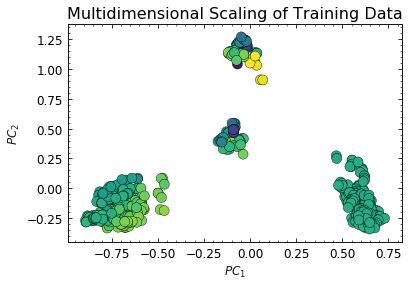

In [16]:
T = np.matmul(U_K[:, :n_MDS], 
              np.diagflat(np.sqrt(v_K[:n_MDS]))
             )
plot_projection(Y_train, T, title="Multidimensional Scaling of Training Data", **cmaps)

## Projecting New Data

Given that our latent-space projection is not given as a function of the input space, how do we project new data? First we reconstruct $\mathbf{T}$ as a function of $\mathbf{X}$ by solving for $\mathbf{P}_{XT}$

\begin{equation}
\mathbf{T} = \mathbf{X}\mathbf{P}_{XT}.
\end{equation}

We solve by multiplying both sides by the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $\mathbf{X}$

\begin{equation}
(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{T} = \mathbf{P}_{XT}.
\end{equation}

In [17]:
PXT = np.linalg.solve(np.dot(X_train.T,X_train),np.dot(X_train.T,T))

.... or as a least-square problem, which is faster and more stable

In [18]:
PXT = np.linalg.lstsq(X_train, T, rcond=None)[0]

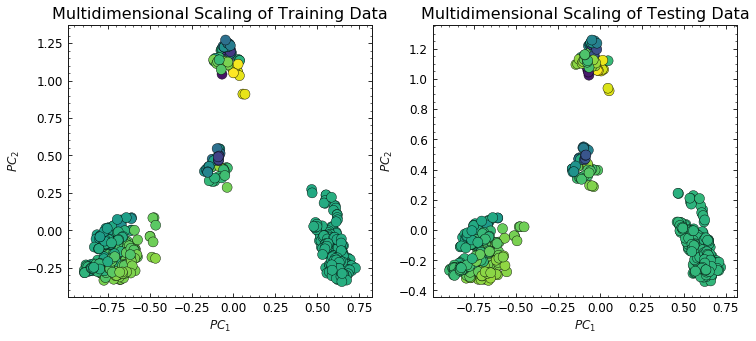

In [19]:
T_test = np.matmul(X_test, PXT)

fig, ax = plt.subplots(1,2, figsize=dbl_fig)
plot_projection(Y_train, T, fig=fig, ax=ax[0], title="Multidimensional Scaling of Training Data", **cmaps)
plot_projection(Y_test, T_test, fig=fig, ax=ax[1], title="Multidimensional Scaling of Testing Data", **cmaps)

## Connection with PCA, and with the SVD of $\mathbf{X}$

We can take advantage of the relationship between the eigenvectors and eigenvalues of the covariance $\mathbf{C} = \mathbf{X}^T\mathbf{X}$ and those of the Gram matrix $\mathbf{K} = \mathbf{X}\mathbf{X}^T$.

In fact, it is possible to show that the singular-value decomposition of 
$\mathbf{X}$ can be written as $\mathbf{X}=\mathbf{U_K}\mathbf{\Sigma}\mathbf{U_C}^T$, where $\mathbf{\Sigma}$ is a rectangular matrix that is full of zeros, except for having the square root of the non-zero eigenvalues of $\mathbf{C}$ or $\mathbf{K}$  (that are the same) on the diagonal.

Then, one sees that 

\begin{equation}
\mathbf{U_K} = \mathbf{X}\mathbf{U_C}\mathbf{\Lambda_C}^{-1/2}
\end{equation}

In [20]:
C = np.matmul(X_train.T, X_train)

v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

And we see that the largest eigenvalues of $\mathbf{C}$ and $\mathbf{K}$ are the same.

2.598668864098337e-13

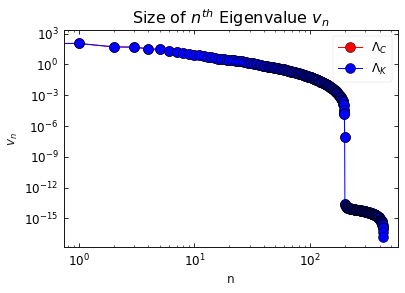

In [21]:
plt.loglog(v_C,"r-", marker='o', label=r'$\Lambda_C$')
plt.loglog(v_K,"b-", marker='o', label=r'$\Lambda_K$')
plt.title(r"Size of $n^{th}$ Eigenvalue $v_n$")
plt.legend()
plt.xlabel("n"); plt.ylabel(r"$v_n$");

np.linalg.norm(v_K[:v_C.shape[0]]-v_C)

Using these relationships we obtain MDS

\begin{equation}
\mathbf{T}=\mathbf{\hat{U}_K}\mathbf{\hat{\Lambda}_K}^{1/2} = \mathbf{X}\mathbf{\hat{U}_C}\mathbf{\hat{\Lambda}_C}^{-1/2}\mathbf{\hat{\Lambda}_K}^{1/2}= \mathbf{X}\hat{\mathbf{U}}_\mathbf{C}
\end{equation}

which shows that MDS and PCA yield the same projection.

In [22]:
T = np.matmul(X_test, PXT)

ref = PCA(n_PC=n_MDS)
ref.fit(X_train)
T_ref = ref.transform(X_test)

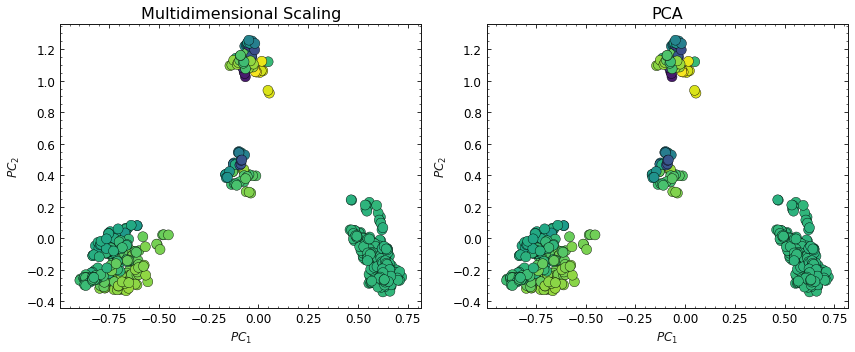

In [23]:
fig, ax = plt.subplots(1,2, figsize=dbl_fig)
plot_projection(Y_test, T, fig=fig, ax=ax[0], title="Multidimensional Scaling", **cmaps)
plot_projection(Y_test, check_mirrors(T_ref,T), fig=fig, ax=ax[1], title="PCA", **cmaps)
fig.tight_layout()

## Error and Variance

As for the case of PCA, we see how the error decreases as the number of components is increased

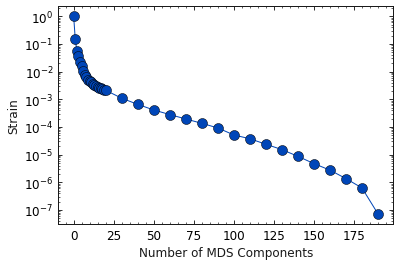

In [24]:
K = np.matmul(X_test, X_test.T)
ns = range(X_train.shape[1])
ns = [*ns[:20], *ns[20::10]]

PXT = np.linalg.lstsq(X_train, np.matmul(U_K, np.diagflat(np.sqrt(v_K))), rcond=None)[0]
T = np.matmul(X_test, PXT)
strains = [(np.linalg.norm(K) - np.linalg.norm(np.matmul(T[:,:n], T[:,:n].T)))/np.linalg.norm(K) for n in ns]


plt.semilogy(ns, strains, marker='o')
plt.xlabel("Number of MDS Components")
plt.ylabel("Strain")
plt.show()

# Linear Regression

## Finding Weights which Minimize Loss
In [linear regression](https://en.wikipedia.org/wiki/Linear_regression#Estimation_methods) (LR), we aim to find a linear relationship between the features (inputs) and target(s) that minimizes the error of the reconstruction of the target variable. In other words, we seek a model 

\begin{equation}
\hat{\mathbf{Y}} = \mathbf{X}\mathbf{P}_{XY},
\end{equation}

where the weights $\mathbf{P}_{XY}$  minimize the loss,

\begin{align}
\ell &= \left\lVert \mathbf{Y} - \hat{\mathbf{Y}}\right\rVert^2\\
&=\left\lVert \mathbf{Y} - \mathbf{X}\mathbf{P}_{XY}\right\rVert^2.
\end{align}

By minimizing the loss function with respect to $\mathbf{P}_{XY}$ using the [matrix relations](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

\begin{align}
(1) & \quad\left\lVert\mathbf{A}\right\rVert^2=\operatorname{Tr}(\mathbf{A}\mathbf{A}^T) \\
(2) & \quad (\mathbf{A}+\mathbf{B})^T = \mathbf{A}^T + \mathbf{B}^T\\
(3) & \quad \operatorname{Tr}(\mathbf{A} + \mathbf{B}) = \operatorname{Tr}(\mathbf{A}) + \operatorname{Tr}(\mathbf{B})\\
(4) & \quad\operatorname{Tr}(\mathbf{A B C}) = \operatorname{Tr}(\mathbf{B C A})\\
(5) & \quad \frac{\partial}{\partial\mathbf{B}} \operatorname{Tr} (\mathbf{AB}^T) = \mathbf{A}\\
(6) & \quad \frac{\partial}{\partial\mathbf{B}} \operatorname{Tr} (\mathbf{ABB}^T\mathbf{A}^T) = 2\mathbf{A}^T\mathbf{AB},\\
\end{align}

one obtains

\begin{equation}
\mathbf{P}_{XY} = (\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^T \mathbf{Y}.
\end{equation}

where $\lambda$ is the small regularization parameter. When $\lambda$ is greater than zero, the model is known as *ridge regression*, corresponding to a $\mathcal{L}^2$ regularization of the loss, i.e. a penalty that is associated with models with large weights

\begin{equation}
\ell = \left\lVert \mathbf{Y} - \mathbf{X}\mathbf{P}_{XY}\right\rVert^2 + \lambda \left\lVert \mathbf{P}_{XY}\right\rVert^2.
\end{equation}

We look at the effect of this regularization parameter in Section 4.3.

In [25]:
regularization=1e-16

XTX = np.matmul(X_train.T, X_train)
XTX = XTX + regularization*np.eye(X_train.shape[1])
iXTX = np.linalg.pinv(XTX)
XTY = np.matmul(X_train.T, Y_train)

PXY = np.matmul(iXTX,XTY)

The prediction for the train (or test) set $\mathbf{X}$ is easily obtained multiplying the features by the weights.

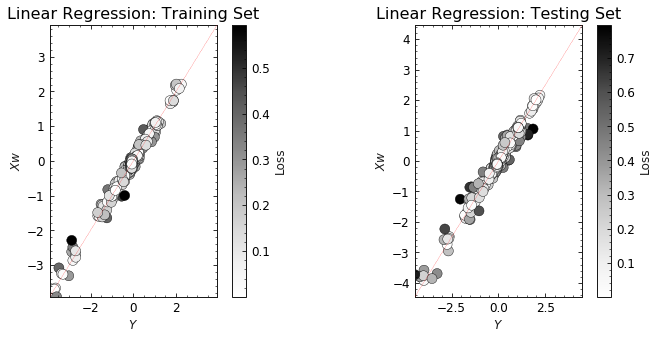

In [26]:
Y_lr_train = np.matmul(X_train, PXY)
Y_lr_test = np.matmul(X_test, PXY)

fig, axes = plt.subplots(1,2, figsize=dbl_fig)

plot_regression(Y_train[:,0], Y_lr_train[:,0], title="Linear Regression: Training Set", fig=fig, ax=axes[0], **cmaps)
plot_regression(Y_test[:,0], Y_lr_test[:,0], title="Linear Regression: Testing Set", fig=fig, ax=axes[1], **cmaps)

## Error and Loss

We then go back and calculate the loss functions from earlier.

In [27]:
table_from_dict([get_stats(x=X_train, y=Y_train, yp=Y_lr_train), 
                 get_stats(x=X_test, y=Y_test, yp=Y_lr_test)], 
                 headers = ["Training", "Testing"], 
                 title="LR")

<center><b> LR </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.981241 </td><td> 0.964062 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 0.00524839 </td><td> 0.00801428 </td></tr></table></center>

## Choosing a Regularization

Adding small amounts of noise to data in regressions leads to a more robust model [(Marquardt 1970)](https://www.tandfonline.com/doi/pdf/10.1080/00401706.1970.10488699?casa_token=ZAXSZfnnkGsAAAAA:aji-q3QyTuSZRkBTTx1k_Z4Fnc3YQimEvJHxSQPzfTwoF6ksV0tbXb06TmP08__yalTAkQpbEszS1co), [(Koistinen 1992)](http://papers.nips.cc/paper/459-kernel-regression-and-backpropagation-training-with-noise.pdf),  [(Gupta 2017)](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a) by reducing the [overfitting](https://en.wikipedia.org/wiki/Overfitting). 
A similar result is achieved by setting an appropriate value for the parameter $\lambda$.

In [28]:
regularizations = np.linspace(-10, 0, 24)
lrs = [LR(regularization=10**i) for i in regularizations]

for lr in lrs:
    lr.fit(X_train, Y_train)

In [29]:
coeff_deter = np.array([lr.statistics(X_test, Y_test)['Coefficient of Determination<br>($R^2$)'] for lr in lrs])

Even small values of the regularization lead to an increase in the fit of the model.

The ideal value of $\lambda$ for this LR (with respect to $R^2$) is 0.0025.


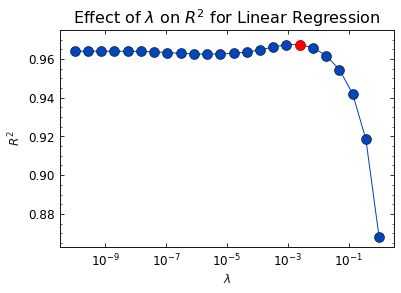

In [30]:
plt.semilogx(10**regularizations, coeff_deter, marker='o')

best_regularization = 10**regularizations[coeff_deter.argmax()]
plt.scatter([best_regularization], 
            [coeff_deter.max()], c='r', zorder=3)

print(f"The ideal value of $\lambda$ for this LR (with respect to $R^2$) is {round(best_regularization,4)}.")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"$R^2$")

plt.title(r"Effect of $\lambda$ on $R^2$ for Linear Regression")

plt.show()

# Next: Combining LR and PCA

In the next notebook, we show how PCA and LR can be combined into a new model. [Continue on -->](2_PrincipalCovariatesRegression.ipynb)

# The Utility Classes

Classes from the utility module enable computing PCA, MDS, and LR with a scikit.learn-like syntax. 

In [31]:
from utilities.classes import PCA, MDS, LR

## PCA

In [32]:
pca = PCA(n_PC=n_PC)

Calling `pca.fit(X)` computes the covariance $\mathbf{C}$ of $\mathbf{X}$ and internally stores the eigenvectors/values.

In [33]:
pca.fit(X_train)

Calling `pca.transform(X)` computes and returns the PCA projection $\mathbf{T}$. We can also use the eigenvectors from the PCA fit to project new data that was not used to originally construct $\mathbf{P}_{XT}$

In [34]:
T_test = pca.transform(X_test)
T_train = pca.transform(X_train)

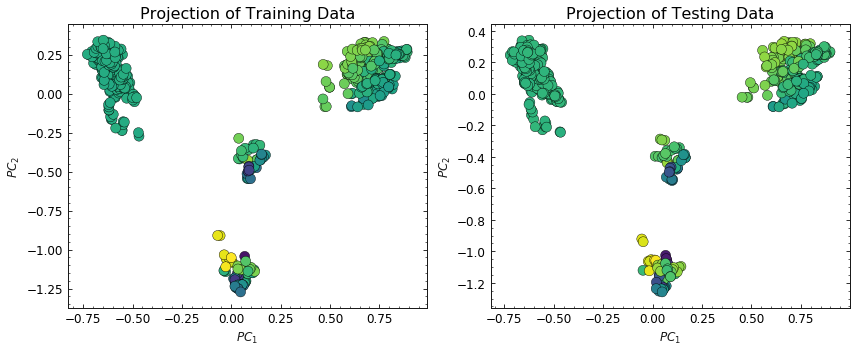

In [35]:
fig, axes = plt.subplots(1,2, figsize=dbl_fig)

plot_projection(Y_train, T_train, title="Projection of Training Data", fig=fig, ax=axes[0], **cmaps)
plot_projection(Y_test, T_test, title="Projection of Testing Data", fig=fig, ax=axes[1], **cmaps)

fig.tight_layout()
plt.show()

Calling `pca.statistics(X)` outputs the statistics of the projection of $\mathbf{X}$.

In [36]:
table_from_dict([pca.statistics(X_train), pca.statistics(X_test)], 
                 headers = ["Training", "Testing"], 
                 title="PCA")

<center><b> PCA </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 1.0142 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.536512 </td><td> 0.539828 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 0.463488 </td><td> 0.474371 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.463488 </td><td> 0.475079 </td></tr></table></center>

### Predicting Properties with our Low-Dimensional Projection

It's possible to use the projection determined by PCA to regress properties in a manner similar to linear regression. For this, we determine a weight $\mathbf{P}_{TY}$ which minimizes

\begin{equation}
\ell = \lVert\mathbf{Y}-\mathbf{T}\mathbf{P}_{TY}\rVert^2 + \lambda \lVert \mathbf{P}_{TY} \rVert^2
\end{equation}

Analogous to LR, we find this weight to be:

\begin{equation}
\mathbf{P}_{TY} = (\mathbf{T}^T \mathbf{T} + \lambda \mathbf{I})^{-1} \mathbf{T}^T \mathbf{Y}.
\end{equation}

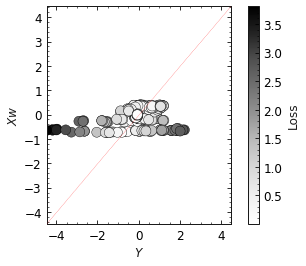

In [37]:
PTY = np.matmul(T_train.T, T_train) + best_regularization*np.eye(T_train.shape[1])
PTY = np.linalg.pinv(PTY)
PTY = np.matmul(PTY, T_train.T)
PTY = np.matmul(PTY, Y_train)

Y_pca = np.matmul(T_test, PTY)
plot_regression(Y_test[:,0], Y_pca[:,0], **cmaps)

Look at how bad that is! As one can imagine, including more components gives a better prediction of the properties.

In [38]:
larger_npca = [10, 50, 100, 200]

all_stats = [get_stats(y=Y_test, yp=Y_pca)]
headers = [r"$n_{PCA}$"+"={}".format(n_PC)]

for n in larger_npca:
    pca2 = PCA(n_PC=n)
    pca2.fit(X_train)

    T_train2 = pca2.transform(X_train)
    T_test2 = pca2.transform(X_test)

    PTY2 = np.matmul(T_train2.T, T_train2) + best_regularization*np.eye(T_train2.shape[1])
    PTY2 = np.linalg.pinv(PTY2)
    PTY2 = np.matmul(PTY2, T_train2.T)
    PTY2 = np.matmul(PTY2, Y_train)

    Y_pca2 = np.matmul(T_test2, PTY2)
    
    all_stats.append(get_stats(y=Y_test, yp=Y_pca2))
    headers.append(r"$n_{PCA}$"+"={}".format(n))

table_from_dict(all_stats,
                 headers = headers, 
                 title="Regression Errors from PCA Projections")

/Applications/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


<center><b> Regression Errors from PCA Projections </b></center><br>                            <center><table><tr><th></th><th><center>$n_{PCA}$=2</center></th><th><center>$n_{PCA}$=10</center></th><th><center>$n_{PCA}$=50</center></th><th><center>$n_{PCA}$=100</center></th><th><center>$n_{PCA}$=200</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.0915542 </td><td> 0.340232 </td><td> 0.905409 </td><td> 0.947381 </td><td> 0.967511 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 0.0402934 </td><td> 0.0343384 </td><td> 0.013002 </td><td> 0.00969738 </td><td> 0.00761995 </td></tr></table></center>

## MDS

A helper class is provided to run MDS with a scikit-learn-like syntax

In [39]:
mds = MDS(n_MDS=n_MDS)

Calling `mds.fit(X)` computes the Gram matrix $\mathbf{K}$ from $\mathbf{X}$ and internally storess the eigenvectors/values.

In [40]:
mds.fit(X_train)

Calling `mds.transform(X)` computes and returns the MDS projection $\mathbf{T}$. We also use the eigenvectors from the MDS fit to project new data that was not used to originally construct the MDS.

In [41]:
T = mds.transform(X_test)

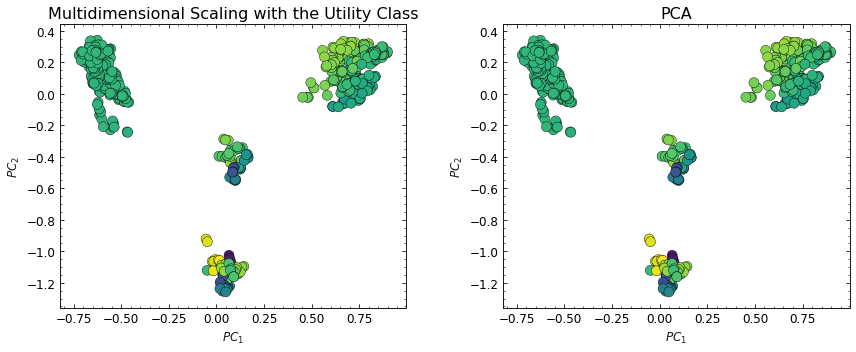

In [42]:
fig, ax = plt.subplots(1,2, figsize=dbl_fig)
plot_projection(Y_test, check_mirrors(T, T_ref), fig=fig, ax=ax[0], title="Multidimensional Scaling with the Utility Class", **cmaps)
plot_projection(Y_test, T_ref, fig=fig, ax=ax[1], title="PCA", **cmaps)
fig.tight_layout()

Calling `mds.statistics(X)` outputs the statistics of the projection of $\mathbf{X}$.

In [43]:
table_from_dict([mds.statistics(X_train), mds.statistics(X_test)], 
                 headers = ["Training", "Testing"], 
                 title="MDS")

<center><b> MDS </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1 </td><td> 1.0142 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.536512 </td><td> 0.539828 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 0.463488 </td><td> 0.474371 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.463488 </td><td> 0.475079 </td></tr><tr><td> Strain </td>                                                <td> 27.1911 </td><td> 29.2169 </td></tr></table></center>

## LR

Unlike PCA, which takes the number of PCA components in the constructor, the linear regression class takes the regularization as a parameter.

In [44]:
lr = LR(regularization=best_regularization)

Calling `lr.fit(X,Y)` computes the weights $\mathbf{P}_{XY}$ and internally stores them.

In [45]:
lr.fit(X_train, Y_train)

Calling `lr.transform(X)` computes and return the predicted $\hat{\mathbf{Y}}$ values from $\hat{\mathbf{Y}}_{LR} = \mathbf{X}\mathbf{P}_{XY}$.

In [46]:
Y_lr_train = lr.transform(X_train)
Y_lr_test = lr.transform(X_test)

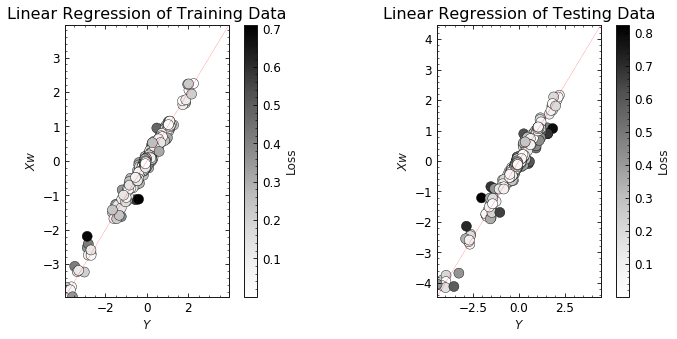

In [47]:
fig, axes = plt.subplots(1,2, figsize=dbl_fig)

plot_regression(Y_train[:,0], Y_lr_train[:,0], title="Linear Regression of Training Data", fig=fig, ax=axes[0], **cmaps)
plot_regression(Y_test[:,0], Y_lr_test[:,0], title="Linear Regression of Testing Data", fig=fig, ax=axes[1], **cmaps)

fig.subplots_adjust(wspace=0.25)
plt.show()

Calling `lr.statistics(X,Y)` outputs the statistics of the regression of $\mathbf{X}$ and $\mathbf{Y}$.

In [48]:
table_from_dict([lr.statistics(X_train, Y_train), lr.statistics(X_test, Y_test)], 
                 headers = ["Training", "Testing"], 
                 title="Linear Regression")

<center><b> Linear Regression </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.976881 </td><td> 0.967511 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 0.00582658 </td><td> 0.00761995 </td></tr></table></center>

# Chemiscope visualization

We can use the `chemiscope_input` function from `utilities/chemiscope.py` to generate an input file for the [chemiscope](https://chemiscope.org/) interactive visualiser. This allow to show how different atomic environements are projected with PCA, or how the predicted properties relate to the structures.

In [49]:
from utilities.chemiscope import chemiscope_input
import ase
from ase import io
import json

In [50]:
frames = ase.io.read("../datasets/CSD-1000R.xyz", ":10")

# We want to have prediction and projection for all the environments
lr = LR(regularization=best_regularization)
lr.fit(X_train, Y_train)
Y_lr_full_scaled = lr.transform(X)
# we have to rescale the properties back to be able to compare them to the actual values
Y_lr_full = Y_scale * Y_lr_full_scaled + Y_center

pca = PCA(n_PC=n_PC)
pca.fit(X_train)
X_pca_full = pca.transform(X)

In [97]:
def _typetransform(data):
    if isinstance(data[0], str):
        return list(map(str, data))
    elif isinstance(data[0], bytes):
        return list(map(lambda u: u.decode('utf8'), data))
    else:
        try:
            return [float(value) for value in data]
        except ValueError:
            raise Exception('unsupported type in property')
def _linearize(name, values):
    '''
    Transform 2D arrays in multiple 1D arrays, converting types to fit json as
    needed.
    '''
    assert isinstance(values, np.ndarray)
    data = {}

    if len(values.shape) == 1:
        data[name] = _typetransform(values)
    elif len(values.shape) == 2:
        for i in range(values.shape[1]):
            data[f'{name}[{i + 1}]'] = _typetransform(values[:, i])
    else:
        raise Exception('unsupported ndarray property')

    return data
def _frame_to_json(frame):
    data = {}
    data['size'] = len(frame)
    data['names'] = list(frame.symbols)
    data['x'] = [float(value) for value in frame.positions[:, 0]]
    data['y'] = [float(value) for value in frame.positions[:, 1]]
    data['z'] = [float(value) for value in frame.positions[:, 2]]

    if (frame.cell.lengths() != [0.0, 0.0, 0.0]).all():
        data['cell'] = list(np.concatenate(frame.cell))

    return data
def _generate_environments(frames, cutoff):
    environments = []
    for frame_id, frame in enumerate(frames):
        for center in range(len(frame)):
            environments.append({
                'structure': frame_id,
                'center': center,
                'cutoff': cutoff,
            })
    return environments


In [108]:
def chemiscope_input(meta, frames, projection, prediction,
                     properties, property_names=None,
                     untrained_properties=None, untrained_property_names=None,
                     cutoff=None,
                    ):
    '''
    Get a dictionary which can be saved as JSON and used as input data for the
    chemiscope visualizer (https://chemiscope.org).

    :param dict meta: metadata of the dataset, see the documentation at
      https://chemiscope.org/docs/tutorial.html#input-file-format-for-chemiscope
      for more information
    :param list frames: list of `ase.Atoms`_ objects containing all the
                        structures
    :param array projection: projection of the structural descriptor in latent
                             space
    :param array prediction: predicted values for the properties for all
                             environments in the frames
    :param array properties: actual value for properties for all environments in
                           the frames
    :param list property_names: name of the properties being considered
    :param array untrained_properties: actual value for properties for all environments in
      the frames that are not included in the regression
    :param list untrained_property_names: name of the untrained properties being considered
    :param float cutoff: optional. If present, will be used to generate
                         atom-centered environments

    .. _`ase.Atoms`: https://wiki.fysik.dtu.dk/ase/ase/atoms.html
    '''
    data = {
        'meta': {
            'name': meta['name'],
            'description': meta.get('description'," "),
            'authors': meta.get('authors',[]),
            'references': meta.get('references',[]),
        }
    }
    projection = np.asarray(projection)
    prediction = np.asarray(prediction)
    property = np.asarray(properties)
    if not property_names:
        property_names = [f'property_{i}' for i in range(properties.shape[1])]

    assert projection.shape[0] == prediction.shape[0]
    assert projection.shape[0] == property.shape[0]
    assert len(property_names) == property.shape[1]
    n_atoms = sum(len(f) for f in frames)

    if projection.shape[0] == len(frames):
        target = 'structure'
    elif projection.shape[0] == n_atoms:
        target = 'atom'
    else:
        raise Exception(
            "the number of features do not match the number of environments"
        )

    error = np.abs(properties - prediction)
    result = {}
    for name, values in _linearize("projection", projection).items():
        result[name] = {"target": target, "values": values}

    for i, property_name in enumerate(property_names):
        for name, values in _linearize(property_name, properties[:, i]).items():
            result[name] = {"target": target, "values": values}

        for name, values in _linearize("predicted {}".format(property_name), prediction[:, i]).items():
            result[name] = {"target": target, "values": values}

        for name, values in _linearize("{} error".format(property_name), error[:, i]).items():
            result[name] = {"target": target, "values": values}

    if(untrained_property_names is not None):
        for i, property_name in enumerate(untrained_property_names):
            for name, values in _linearize(property_name, untrained_properties[:, i]).items():
                result[name] = {"target": target, "values": values}

    data['properties'] = result
    data['structures'] = [_frame_to_json(frame) for frame in frames]

    if cutoff is not None:
        data['environments'] = _generate_environments(frames, cutoff)

    return data

In [109]:
data = chemiscope_input(
    # Dataset name
    meta={'name':"CSD-1000R"},
    # Structures in the dataset
    frames=frames,
    # projection of the dataset, and properties predictions
    projection=X_pca_full,
    prediction=np.array(Y_lr_full[:, 0]).reshape(len(Y_lr_full[:, 0]),1),
    properties=np.array(Y[:, 0]).reshape(len(Y[:, 0]),1),
    property_names=["chemical shieldings"],
    # This should be the same cutoff used to generate the features
    cutoff=3.5,
)

with open("../CSD-1000R.json", "w") as fd:
    json.dump(data, fd)

Loading `CSD-1000R.json` at https://chemiscope.org/ should give you something that looks like the screenshot below. On the left, you can change what is displayed to look at PCA projection or LR regressions variables; and on the right you can see the corresponding atomic environment.

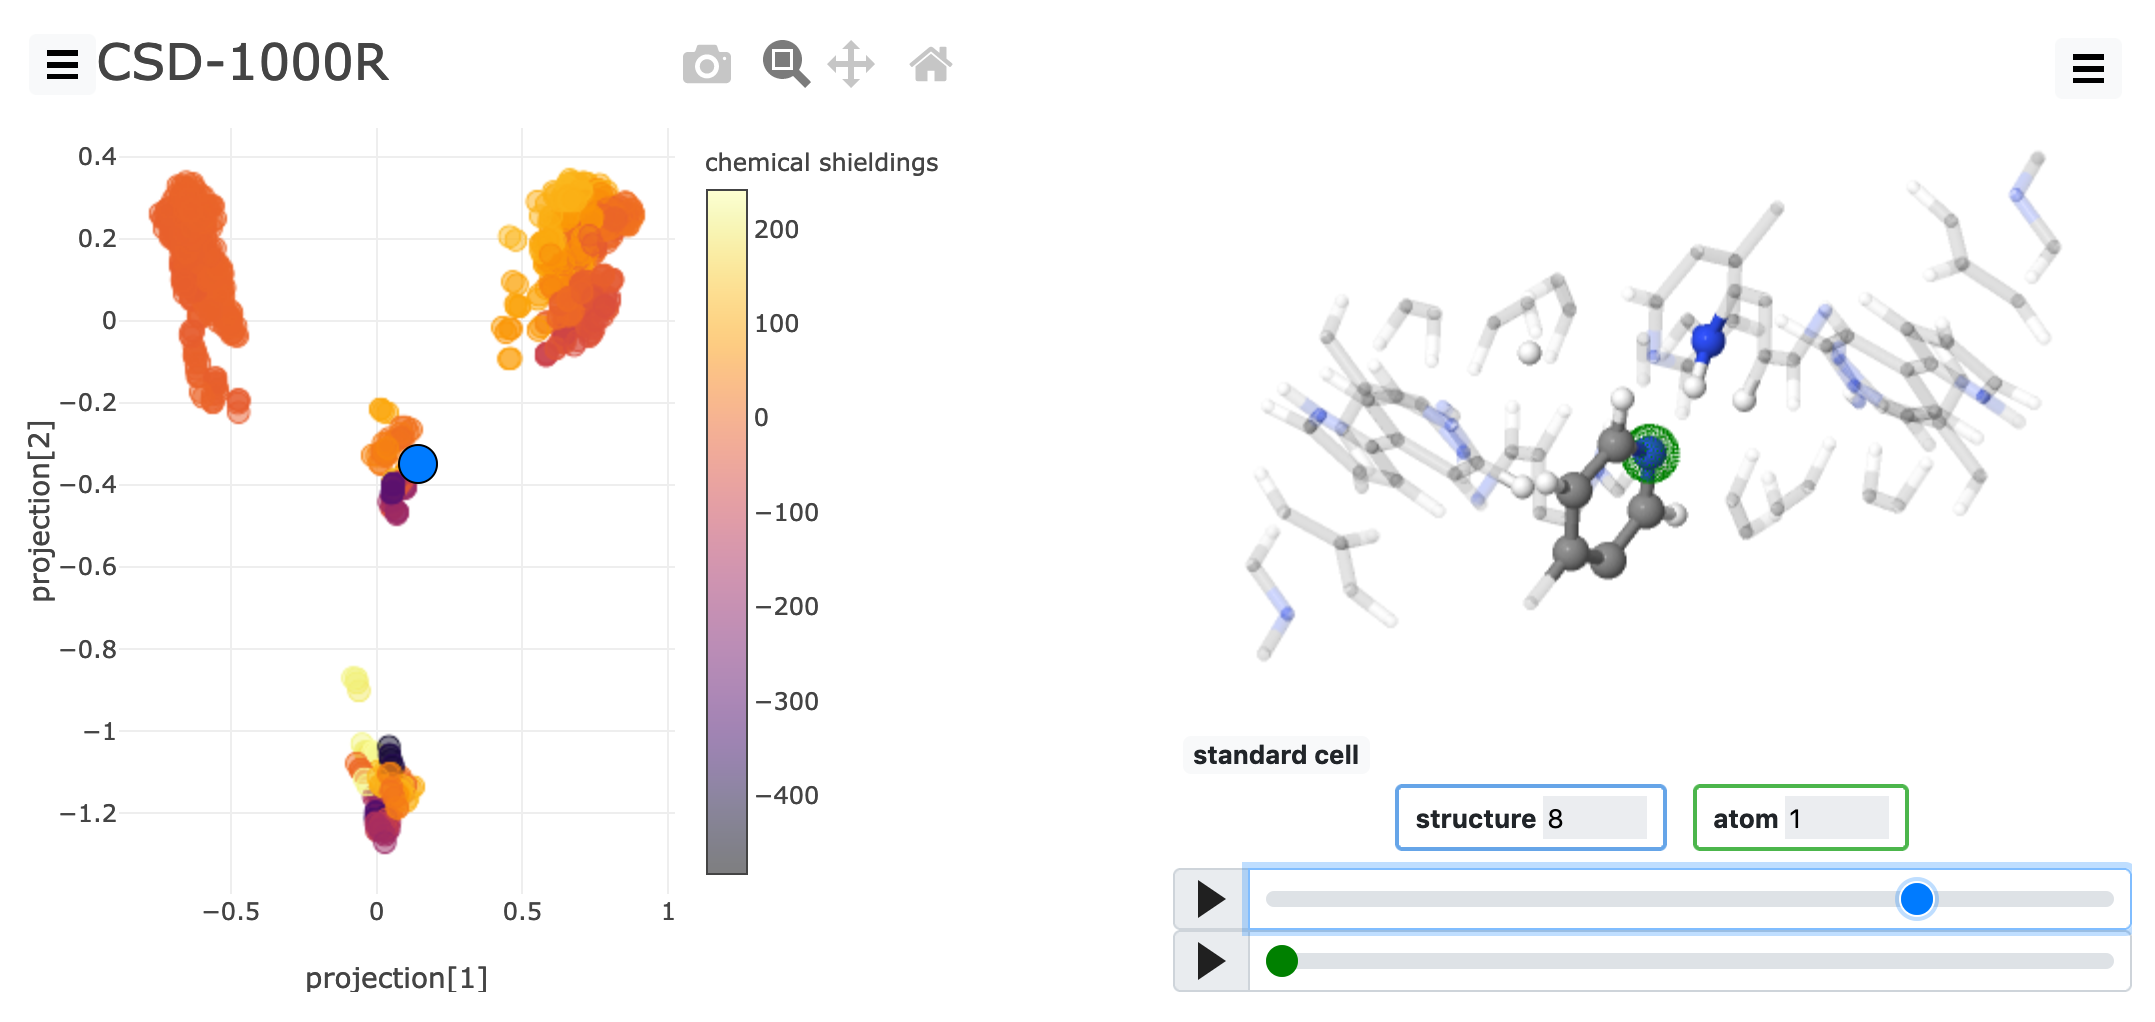